# Kaggle Playground - Loan Payback Prediction

### 1. Importing Libraries

In [1]:
# Core Data Science Libraries
import numpy as np
import pandas as pd
import warnings
import gc

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for Preprocessing and Modeling
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import roc_auc_score
from scipy.stats import rankdata

# Machine Learning Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

# Hyperparameter Tuning
import optuna

# Notebook settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
optuna.logging.set_verbosity(optuna.logging.WARNING)

### 2. Loading Dataset

In [2]:
# Define file paths
TRAIN_PATH = "/kaggle/input/playground-series-s5e11/train.csv"
TEST_PATH = "/kaggle/input/playground-series-s5e11/test.csv"
SUBMISSION_PATH = "/kaggle/input/playground-series-s5e11/sample_submission.csv"

# Load the datasets
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_submission = pd.read_csv(SUBMISSION_PATH)

In [3]:
RANDOM_STATE = 42
N_OPTUNA_TRIALS = 75  # Ideal is between 50-100
N_SPLITS = 10 # Ideal 10

TARGET = 'loan_paid_back'

In [4]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (593994, 13)
Test shape: (254569, 12)


### 3. Feature Engineering

In [5]:
def complete_feature_engineering(df):
    """
    Comprehensive feature engineering pipeline for loan prediction
    """
    df = df.copy()
    
    # 1. FINANCIAL RATIOS (with division protection)
    df['loan_to_income_ratio'] = df['loan_amount'] / (df['annual_income'] + 1)
    df['monthly_income'] = df['annual_income'] / 12
    df['monthly_payment_estimate'] = (df['loan_amount'] * df['interest_rate']) / 100  
    df['payment_to_income_ratio'] = df['monthly_payment_estimate'] / (df['monthly_income'] + 1)
    df['current_debt_amount'] = df['debt_to_income_ratio'] * df['annual_income']
    df['total_debt_with_loan'] = df['current_debt_amount'] + df['loan_amount']
    df['new_debt_to_income'] = df['total_debt_with_loan'] / (df['annual_income'] + 1)
    df['debt_increase_ratio'] = df['new_debt_to_income'] / (df['debt_to_income_ratio'] + 1e-6)
    df['disposable_income'] = df['annual_income'] - df['current_debt_amount']
    df['disposable_income_ratio'] = df['disposable_income'] / (df['annual_income'] + 1)
    df['loan_to_disposable_income'] = df['loan_amount'] / (df['disposable_income'] + 1)
    df['monthly_disposable_income'] = df['disposable_income'] / 12
    df['payment_to_disposable_ratio'] = df['monthly_payment_estimate'] / (df['monthly_disposable_income'] + 1)
    df['annual_payment_burden'] = df['monthly_payment_estimate'] * 12
    df['payment_burden_ratio'] = df['annual_payment_burden'] / (df['annual_income'] + 1)

    # 2. CREDIT SCORE FEATURES 
    df['credit_score_normalized'] = df['credit_score'] / 850
    df['credit_risk_score'] = 1 - df['credit_score_normalized']
    df['credit_score_squared'] = df['credit_score'] ** 2
    df['credit_score_log'] = np.log1p(df['credit_score'])
    df['credit_category'] = pd.cut(df['credit_score'], bins=[0, 580, 670, 740, 800, 850],
                                 labels=['poor', 'fair', 'good', 'very_good', 'excellent'],
                                 include_lowest=True)
    df['credit_income_interaction'] = df['credit_score'] * df['annual_income']
    df['credit_times_dti'] = df['credit_score'] * df['debt_to_income_ratio']
    df['credit_loan_interaction'] = df['credit_score'] * df['loan_amount']

    # 3. INTEREST RATE FEATURES (with division protection)
    df['high_interest_flag'] = (df['interest_rate'] > df['interest_rate'].median()).astype(int)
    df['very_high_interest'] = (df['interest_rate'] > df['interest_rate'].quantile(0.75)).astype(int)
    df['low_interest_flag'] = (df['interest_rate'] < df['interest_rate'].quantile(0.25)).astype(int)
    df['total_interest_cost'] = df['loan_amount'] * df['interest_rate'] / 100
    df['interest_burden'] = df['total_interest_cost'] / (df['annual_income'] + 1)
    df['interest_credit_mismatch'] = df['interest_rate'] * (1 - df['credit_score_normalized'])
    df['interest_credit_ratio'] = df['interest_rate'] / (df['credit_score'] / 100 + 1e-6)
    df['interest_rate_squared'] = df['interest_rate'] ** 2

    # 4. RISK SCORES 
    df['risk_score_v1'] = (df['debt_to_income_ratio'] * 0.25 + df['loan_to_income_ratio'] * 0.25 +
                            df['credit_risk_score'] * 0.30 + (df['interest_rate'] / 100) * 0.20)
    df['risk_score_v2'] = (df['payment_to_income_ratio'] * 0.40 + df['new_debt_to_income'] * 0.35 +
                            df['interest_burden'] * 0.25)
    df['affordability_score'] = (df['credit_score_normalized'] * 0.40 +
                                (1 - df['debt_to_income_ratio']) * 0.30 +
                                df['disposable_income_ratio'] * 0.30)
    df['financial_health_score'] = df['affordability_score'] * 0.60 - df['risk_score_v1'] * 0.40

    # 5. LOAN AMOUNT FEATURES 
    df['loan_size'] = pd.cut(df['loan_amount'], bins=[0, 10000, 20000, 30000, np.inf],
                             labels=['small', 'medium', 'large', 'very_large'],
                             include_lowest=True)
    df['loan_amount_squared'] = df['loan_amount'] ** 2
    df['loan_amount_log'] = np.log1p(df['loan_amount'])
    df['annual_income_log'] = np.log1p(df['annual_income'])
    df['loan_amount_sqrt'] = np.sqrt(df['loan_amount'])

    # 6. BINNING FEATURES
    df['income_decile'] = pd.qcut(df['annual_income'], q=10, labels=False, duplicates='drop')
    df['credit_decile'] = pd.qcut(df['credit_score'], q=10, labels=False, duplicates='drop')
    df['loan_decile'] = pd.qcut(df['loan_amount'], q=10, labels=False, duplicates='drop')
    df['dti_decile'] = pd.qcut(df['debt_to_income_ratio'], q=10, labels=False, duplicates='drop')
    df['interest_decile'] = pd.qcut(df['interest_rate'], q=10, labels=False, duplicates='drop')

    # 7. INTERACTION FEATURES 
    df['income_x_credit'] = df['annual_income'] * df['credit_score']
    df['dti_x_interest'] = df['debt_to_income_ratio'] * df['interest_rate']
    df['loan_x_interest'] = df['loan_amount'] * df['interest_rate']
    df['income_x_dti'] = df['annual_income'] * df['debt_to_income_ratio']
    df['income_credit_loan'] = (df['annual_income'] * df['credit_score']) / (df['loan_amount'] + 1)
    df['dti_interest_credit'] = (df['debt_to_income_ratio'] * df['interest_rate']) / (df['credit_score_normalized'] + 1e-6)

    # 8. GRADE FEATURES (with NaN protection)
    df['grade'] = df['grade_subgrade'].str[0]
    df['subgrade_num'] = pd.to_numeric(df['grade_subgrade'].str[1:], errors='coerce')
    grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
    df['grade_numeric'] = df['grade'].map(grade_map)
    df['full_grade_score'] = df['grade_numeric'] * 10 + df['subgrade_num']
    df['grade_credit_ratio'] = df['full_grade_score'] / (df['credit_score'] / 100 + 1e-6)

    # 9. STATISTICAL AGGREGATIONS 
    financial_metrics = ['debt_to_income_ratio', 'loan_to_income_ratio', 'payment_to_income_ratio']
    df['mean_financial_metrics'] = df[financial_metrics].mean(axis=1)
    df['max_financial_burden'] = df[financial_metrics].max(axis=1)
    df['min_financial_burden'] = df[financial_metrics].min(axis=1)
    df['std_financial_metrics'] = df[financial_metrics].std(axis=1)

    # 10. CATEGORICAL COMBINATIONS 
    df['gender_marital'] = df['gender'] + '_' + df['marital_status']
    df['education_employment'] = df['education_level'] + '_' + df['employment_status']
    df['gender_education'] = df['gender'] + '_' + df['education_level']
    df['marital_employment'] = df['marital_status'] + '_' + df['employment_status']
    df['purpose_grade'] = df['loan_purpose'] + '_' + df['grade']
    df['employment_purpose'] = df['employment_status'] + '_' + df['loan_purpose']

    # 11. ANOMALY FLAGS 
    df['extreme_dti'] = (df['debt_to_income_ratio'] > df['debt_to_income_ratio'].quantile(0.95)).astype(int)
    df['low_income'] = (df['annual_income'] < df['annual_income'].quantile(0.25)).astype(int)
    df['large_loan'] = (df['loan_amount'] > df['loan_amount'].quantile(0.75)).astype(int)
    df['risky_combo_1'] = ((df['debt_to_income_ratio'] > 0.4) & (df['credit_score'] < 600)).astype(int)
    df['risky_combo_2'] = ((df['loan_to_income_ratio'] > 0.5) & (df['interest_rate'] > 15)).astype(int)
    df['safe_combo'] = ((df['credit_score'] > 750) & (df['debt_to_income_ratio'] < 0.1)).astype(int)
    df['high_risk_all'] = (df['extreme_dti'] & df['risky_combo_1']).astype(int)

    return df

In [6]:
print("Starting Feature Engineering...")
train_fe = complete_feature_engineering(train)
test_fe = complete_feature_engineering(test)
print("Feature Engineering Complete.")

# Handle NaNs and infinite values created during FE
print("Checking for NaNs and infinite values...")
for df, name in [(train_fe, 'train'), (test_fe, 'test')]:
    nan_counts = df.isna().sum().sum()
    inf_counts = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
    print(f"{name} - NaNs: {nan_counts}, Infs: {inf_counts}")

# Fill NaNs in numeric columns with median
numeric_cols = train_fe.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col not in [TARGET, 'id']:
        median_val = train_fe[col].median()
        train_fe[col] = train_fe[col].fillna(median_val)
        test_fe[col] = test_fe[col].fillna(median_val)
        
# Fill NaNs in categorical columns with mode
categorical_cols = train_fe.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    if col in train_fe.columns:
        mode_val = train_fe[col].mode()[0]
        train_fe[col] = train_fe[col].fillna(mode_val)
        test_fe[col] = test_fe[col].fillna(mode_val)

gc.collect()

Starting Feature Engineering...
Feature Engineering Complete.
Checking for NaNs and infinite values...
train - NaNs: 0, Infs: 0
test - NaNs: 0, Infs: 0


40

### 4. Preprocessing

In [7]:
y = train[TARGET]

# Identify categorical and numerical features
cat_features = train_fe.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = train_fe.select_dtypes(include=[np.number]).columns.tolist()

# Remove target and ID from feature lists
for col in [TARGET, 'id']:
    if col in num_features:
        num_features.remove(col)
    if col in cat_features:
        cat_features.remove(col)

# Explicitly remove grade_subgrade if present
if 'grade_subgrade' in cat_features:
    cat_features.remove('grade_subgrade')

print(f"Categorical Features: {len(cat_features)} - {cat_features[:10]}{'...' if len(cat_features) > 10 else ''}")
print(f"Numerical Features: {len(num_features)}")

# Ordinal Encoding for all categorical features
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
if len(cat_features) > 0:
    train_fe[cat_features] = encoder.fit_transform(train_fe[cat_features])
    test_fe[cat_features] = encoder.transform(test_fe[cat_features])
    
    # FIX: Convert encoded categorical features to integer type for CatBoost
    for col in cat_features:
        train_fe[col] = train_fe[col].astype('int64')
        test_fe[col] = test_fe[col].astype('int64')

# Standard Scaling for numerical features
scaler = StandardScaler()
if len(num_features) > 0:
    train_fe[num_features] = scaler.fit_transform(train_fe[num_features])
    test_fe[num_features] = scaler.transform(test_fe[num_features])

# Combine features for modeling
features = num_features + cat_features
X = train_fe[features]
X_test = test_fe[features]

print(f"Final feature count: {len(features)}")
gc.collect()

Categorical Features: 14 - ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'credit_category', 'loan_size', 'grade', 'gender_marital', 'education_employment']...
Numerical Features: 69
Final feature count: 83


0

### 5. Hyperparameter Tuning (Optuna)

In [8]:
# Create a single validation split for quick Optuna tuning
X_train_tune, X_val_tune, y_train_tune, y_val_tune = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Get feature indices for CatBoost
cat_features_indices = [X.columns.get_loc(c) for c in cat_features if c in X.columns]

In [9]:
def objective_lgbm(trial):
    param = {
        'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0,
        'objective': 'binary', 'metric': 'auc',
        'boosting_type': 'gbdt', 
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'random_state': RANDOM_STATE, 'verbosity': -1, 'n_jobs': -1
    }

    model = LGBMClassifier(**param)
    model.fit(X_train_tune, y_train_tune, 
              eval_set=[(X_val_tune, y_val_tune)], 
              eval_metric='auc', 
              callbacks=[lgb.early_stopping(100, verbose=False)])
    
    y_pred_proba = model.predict_proba(X_val_tune)[:, 1]
    auc = roc_auc_score(y_val_tune, y_pred_proba)
    return auc

print("Tuning LGBMClassifier...")
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=N_OPTUNA_TRIALS)
best_params_lgb = study_lgbm.best_params
print(f"Best LGBM Params: {best_params_lgb}")
print(f"Best LGBM AUC: {study_lgbm.best_value}")

def objective_xgb(trial):
    param = {
        'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'gpu_id': 0,
        'objective': 'binary:logistic', 'eval_metric': 'auc',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.7, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.7, 0.9, 1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000, step=100),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        'random_state': RANDOM_STATE, 'n_jobs': -1
    }

    model = XGBClassifier(**param)
    model.fit(X_train_tune, y_train_tune, 
              eval_set=[(X_val_tune, y_val_tune)], 
              early_stopping_rounds=100, 
              verbose=False)
    
    y_pred_proba = model.predict_proba(X_val_tune)[:, 1]
    auc = roc_auc_score(y_val_tune, y_pred_proba)
    return auc

print("Tuning XGBClassifier...")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=N_OPTUNA_TRIALS)
best_params_xgb = study_xgb.best_params
print(f"Best XGB Params: {best_params_xgb}")
print(f"Best XGB AUC: {study_xgb.best_value}")

def objective_cat(trial):
    param = {
        'task_type': 'GPU', 'devices': '0',
        'loss_function': 'Logloss', 'eval_metric': 'AUC',
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 128, 254),
        'random_seed': RANDOM_STATE, 'logging_level': 'Silent',
        'early_stopping_rounds': 100
    }

    train_pool = Pool(X_train_tune, y_train_tune, cat_features=cat_features_indices)
    val_pool = Pool(X_val_tune, y_val_tune, cat_features=cat_features_indices)
    
    model = CatBoostClassifier(**param)
    model.fit(train_pool, eval_set=val_pool, verbose=0)
    
    y_pred_proba = model.predict_proba(val_pool)[:, 1]
    auc = roc_auc_score(y_val_tune, y_pred_proba)
    return auc

print("Tuning CatBoostClassifier...")
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=N_OPTUNA_TRIALS)
best_params_cat = study_cat.best_params
print(f"Best CAT Params: {best_params_cat}")
print(f"Best CAT AUC: {study_cat.best_value}")

Tuning LGBMClassifier...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Best LGBM Params: {'n_estimators': 1400, 'learning_rate': 0.04345243854842753, 'num_leaves': 34, 'max_depth': 11, 'lambda_l1': 0.018796476288792805, 'lambda_l2': 4.919050060035121, 'feature_fraction': 0.8412897015576313, 'bagging_fraction': 0.9148927849798663, 'bagging_freq': 4, 'min_child_samples': 65}
Best LGBM AUC: 0.9216858178355751
Tuning XGBClassifier...
Best XGB Params: {'lambda': 3.510752812302435, 'alpha': 6.570085511779615, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0980440237552117, 'n_estimators': 1100, 'max_depth': 4, 'min_child_weight': 30}
Best XGB AUC: 0.9214551312668421
Tuning CatBoostClassifier...


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric perio

Best CAT Params: {'iterations': 1948, 'learning_rate': 0.09934652158001522, 'depth': 5, 'l2_leaf_reg': 7.448080530235011, 'random_strength': 0.0286381293133529, 'bagging_temperature': 0.056584573240827746, 'border_count': 246}
Best CAT AUC: 0.92182567892815


### 6. Model Training (Cross-Validation with Tuned Params)

In [10]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# OOF and Test Predictions Arrays
lgb_oof = np.zeros(len(X))
xgb_oof = np.zeros(len(X))
cat_oof = np.zeros(len(X))

lgb_test = np.zeros(len(X_test))
xgb_test = np.zeros(len(X_test))
cat_test = np.zeros(len(X_test))

# Score Lists
lgb_scores = []
xgb_scores = []
cat_scores = []

# --- Add final GPU/Fixed params to the tuned params ---
best_params_lgb.update({'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0, 'objective': 'binary', 'metric': 'auc', 'random_state': RANDOM_STATE, 'verbosity': -1, 'n_jobs': -1})
best_params_xgb.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'gpu_id': 0, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': RANDOM_STATE, 'n_jobs': -1})
best_params_cat.update({'task_type': 'GPU', 'devices': '0', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'random_seed': RANDOM_STATE, 'logging_level': 'Silent', 'early_stopping_rounds': 100})

# FIXED: Rename models to avoid shadowing imported modules
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # --- 1. LightGBM ---
    print("Training LightGBM...")
    lgb_model = LGBMClassifier(**best_params_lgb)
    lgb_model.fit(X_train, y_train, 
                  eval_set=[(X_val, y_val)], 
                  eval_metric='auc', 
                  callbacks=[lgb.early_stopping(100, verbose=False)])
    
    lgb_oof[val_idx] = lgb_model.predict_proba(X_val)[:, 1]
    lgb_test += lgb_model.predict_proba(X_test)[:, 1] / N_SPLITS
    lgb_scores.append(roc_auc_score(y_val, lgb_oof[val_idx]))

    # --- 2. XGBoost ---
    print("Training XGBoost...")
    xgb_model = XGBClassifier(**best_params_xgb)
    xgb_model.fit(X_train, y_train, 
                  eval_set=[(X_val, y_val)], 
                  early_stopping_rounds=100, 
                  verbose=False)
    
    xgb_oof[val_idx] = xgb_model.predict_proba(X_val)[:, 1]
    xgb_test += xgb_model.predict_proba(X_test)[:, 1] / N_SPLITS
    xgb_scores.append(roc_auc_score(y_val, xgb_oof[val_idx]))

    # --- 3. CatBoost ---
    print("Training CatBoost...")
    train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
    val_pool = Pool(X_val, y_val, cat_features=cat_features_indices)
    
    cat_model = CatBoostClassifier(**best_params_cat)
    cat_model.fit(train_pool, eval_set=val_pool, verbose=0)
    
    cat_oof[val_idx] = cat_model.predict_proba(val_pool)[:, 1]
    cat_test += cat_model.predict_proba(X_test)[:, 1] / N_SPLITS
    cat_scores.append(roc_auc_score(y_val, cat_oof[val_idx]))
    
    print(f"Fold {fold+1} Scores: LGB={lgb_scores[-1]:.6f}, XGB={xgb_scores[-1]:.6f}, CAT={cat_scores[-1]:.6f}")
    
    # FIXED: Clean up with correct variable names
    del lgb_model, xgb_model, cat_model, train_pool, val_pool
    gc.collect()

# --- Final OOF Scores ---
lgb_score = roc_auc_score(y, lgb_oof)
xgb_score = roc_auc_score(y, xgb_oof)
cat_score = roc_auc_score(y, cat_oof)

print(f"\n--- Overall OOF Scores ---")
print(f"LightGBM OOF AUC: {lgb_score:.6f}")
print(f"XGBoost OOF AUC:  {xgb_score:.6f}")
print(f"CatBoost OOF AUC: {cat_score:.6f}")

--- Fold 1/10 ---
Training LightGBM...
Training XGBoost...
Training CatBoost...


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 Scores: LGB=0.924286, XGB=0.923987, CAT=0.924506
--- Fold 2/10 ---
Training LightGBM...
Training XGBoost...
Training CatBoost...


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 Scores: LGB=0.921874, XGB=0.922076, CAT=0.922226
--- Fold 3/10 ---
Training LightGBM...
Training XGBoost...
Training CatBoost...


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 Scores: LGB=0.923101, XGB=0.922762, CAT=0.923268
--- Fold 4/10 ---
Training LightGBM...
Training XGBoost...
Training CatBoost...


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 Scores: LGB=0.922977, XGB=0.922613, CAT=0.923028
--- Fold 5/10 ---
Training LightGBM...
Training XGBoost...
Training CatBoost...


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 Scores: LGB=0.919562, XGB=0.919196, CAT=0.919672
--- Fold 6/10 ---
Training LightGBM...
Training XGBoost...
Training CatBoost...


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 6 Scores: LGB=0.922665, XGB=0.922402, CAT=0.923243
--- Fold 7/10 ---
Training LightGBM...
Training XGBoost...
Training CatBoost...


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 7 Scores: LGB=0.921292, XGB=0.921011, CAT=0.921392
--- Fold 8/10 ---
Training LightGBM...
Training XGBoost...
Training CatBoost...


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 8 Scores: LGB=0.922744, XGB=0.922695, CAT=0.923413
--- Fold 9/10 ---
Training LightGBM...
Training XGBoost...
Training CatBoost...


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 9 Scores: LGB=0.921074, XGB=0.921023, CAT=0.920714
--- Fold 10/10 ---
Training LightGBM...
Training XGBoost...
Training CatBoost...


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 10 Scores: LGB=0.921959, XGB=0.922080, CAT=0.922528

--- Overall OOF Scores ---
LightGBM OOF AUC: 0.922145
XGBoost OOF AUC:  0.921981
CatBoost OOF AUC: 0.922399


### 7. Ensembling

In [11]:
# Model Comparison 
print("\nMODEL COMPARISON")
comparison = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'CatBoost'],
    'OOF AUC': [lgb_score, xgb_score, cat_score]
}).sort_values('OOF AUC', ascending=False)
print(comparison)


MODEL COMPARISON
      Model   OOF AUC
2  CatBoost  0.922399
0  LightGBM  0.922145
1   XGBoost  0.921981


In [12]:
# Create Ensemble 
print("\nCREATING ENSEMBLE")

# 1. Simple Average
simple_oof = (lgb_oof + xgb_oof + cat_oof) / 3
simple_test = (lgb_test + xgb_test + cat_test) / 3
simple_score = roc_auc_score(y, simple_oof)

# 2. Weighted Average 
total_auc = lgb_score + xgb_score + cat_score
w_lgb = lgb_score / total_auc
w_xgb = xgb_score / total_auc
w_cat = cat_score / total_auc
weighted_oof = (lgb_oof * w_lgb) + (xgb_oof * w_xgb) + (cat_oof * w_cat)
weighted_test = (lgb_test * w_lgb) + (xgb_test * w_xgb) + (cat_test * w_cat)
weighted_score = roc_auc_score(y, weighted_oof)

# 3. Rank Average 
rank_oof = (rankdata(lgb_oof) + rankdata(xgb_oof) + rankdata(cat_oof)) / (3 * len(lgb_oof))
rank_test = (rankdata(lgb_test) + rankdata(xgb_test) + rankdata(cat_test)) / (3 * len(lgb_test))
rank_score = roc_auc_score(y, rank_oof)

# Ensemble Results
ensemble_results = pd.DataFrame({
    'Ensemble': ['Simple Average', 'Weighted Average', 'Rank Average'],
    'OOF AUC': [simple_score, weighted_score, rank_score]
}).sort_values('OOF AUC', ascending=False) 

print("\nEnsemble Results:")
print(ensemble_results)
print(f"\nWeights: LGB={w_lgb:.3f}, XGB={w_xgb:.3f}, CAT={w_cat:.3f}")

# Choose best
best_idx = ensemble_results['OOF AUC'].idxmax()
best_name = ensemble_results.loc[best_idx, 'Ensemble']
best_score = ensemble_results.loc[best_idx, 'OOF AUC']

if best_name == 'Simple Average':
    final_preds = simple_test
elif best_name == 'Weighted Average':
    final_preds = weighted_test
else:
    final_preds = rank_test 

print(f"\nBest Ensemble: {best_name} (AUC: {best_score:.6f})")


CREATING ENSEMBLE

Ensemble Results:
           Ensemble   OOF AUC
2      Rank Average  0.922690
1  Weighted Average  0.922669
0    Simple Average  0.922669

Weights: LGB=0.333, XGB=0.333, CAT=0.333

Best Ensemble: Rank Average (AUC: 0.922690)


### 8. Submission

In [13]:
print("\n--- Submission ---")
submission = pd.DataFrame({'id': test['id'], TARGET: final_preds})
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")
display(submission.head())


--- Submission ---
Submission file created successfully!


,id,loan_paid_back
0,593994,0.488998
1,593995,0.776909
2,593996,0.128379
3,593997,0.481165
4,593998,0.635799


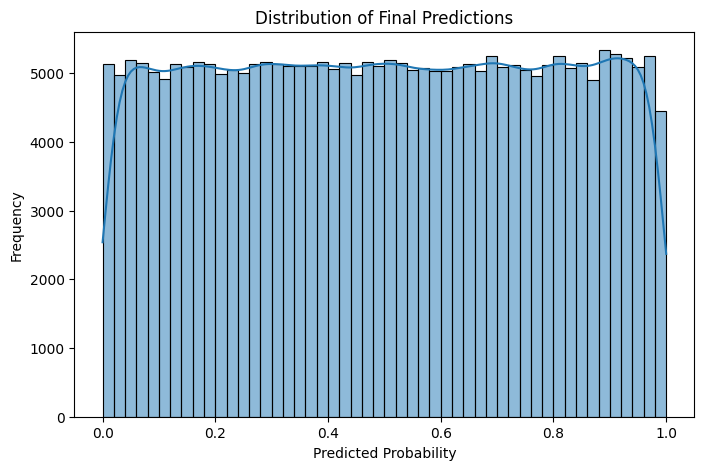

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(submission[TARGET], bins=50, kde=True)
plt.title('Distribution of Final Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()